<center><font size="7">Comparaison Historic Car's Behavior</font></center>

<font size="4">Copyright Christophe PERE 02/05/2017</font>

<b><i>What's the goal of this study ? </i></b>

- To compare the different datasets (annual data of the crawl)
- To determine the depreciation for one model each year and compare between all the years
- To conclude about the behavior and how it can be estimate

The size of all the csv files correspond to 12Go so, to easily use it, subdatasets have been created for all the PSA's brand, Renault and the luxe vehicles (Mercedes, AUDI, BMW). 

Becomming by import the great packages needed to this study

In [1]:
# ---- import modules ----------------------------------------------------------------------------------------------
# to see graph 
%matplotlib inline                                    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.optimize import leastsq
import matplotlib.gridspec as gridspec

Load the names of all the files (one per year)

In [2]:
brand = 'PSA'
folder= '../Docs/Scoring/Scoring_'+brand+'/' 
name  = folder+'Scoring_'+brand+'_2007.csv'
name1 = folder+'Scoring_'+brand+'_2008.csv'
name2 = folder+'Scoring_'+brand+'_2009.csv'
name3 = folder+'Scoring_'+brand+'_2010.csv'
name4 = folder+'Scoring_'+brand+'_2011.csv'
name5 = folder+'Scoring_'+brand+'_2012.csv'
name6 = folder+'Scoring_'+brand+'_2013.csv'
name7 = folder+'Scoring_'+brand+'_2014.csv'
name8 = folder+'Scoring_'+brand+'_2015.csv'
name9 = folder+'Scoring_'+brand+'_2016.csv'
name10= folder+'Scoring_'+brand+'_2017.csv'

Below, different functions developped to select, clean and make computations on the dataframes. 

In [3]:
def func_treatment(data, head, year, col):

    pd.options.mode.chained_assignment = None                       # permit to avoid error in copying 
    
    cols = col 
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors='coerce')           # cast the type str to numeric
        
    # Select a part of the dataframe where the year is > at year passed in the function 
    data = data[(data[head[3]].astype(int)<=datetime.now().year) & (data[head[3]].astype(int)>=year) ]
    data = data[data[head[4]]>0]
    date = [datetime(data[head[3]].iat[i],data[head[4]].iat[i],1) for i in range(len(data))]
    data['Date'] = date                                             # .astype() permit to cast a type to another     
                                                                    # passed in the () 
    # ---- Create the age to compare --------------------------------    
    #print(data.data_month[:5])
    if(len(data)>0):
        test=data.data_month.iat[0].split('_')
        if(len(test)>1):
            data_month = [i.split('_') for i in data.data_month.values]
        else:
            data_month = [i.split('-') for i in data.data_month.values]
        #print('third',data_month[:5])
    #print (data_month[:5])
    else:
        data_month = []
    data_month = [datetime(int(i[0]),int(i[1]),1) for i in data_month]          # make a datetime
    date_age=[round((data_month[i]-date[i]).days/30) for i in range(len(date))] # compute the age in months
    
    data['Age_months']=date_age                                                 # save in a new column
    data = data[data.Age_months>=0]                                             # keep all positive or null age 
    # ---- Data cleaning --------------------------------------------
    a = data[head[0]].fillna(' ')
    data[head[0]] = a.values
    a = data[head[1]].apply(lambda x : x if x>0 else 0 )
    data[head[1]] = a.values    
    return data

def func_outliers(data):                                       # remove outliers from data
    data=data[data.Prix<100000]
    data=data[data.Prix>500]
    years = data[head[3]].unique()                             # list of years unique
    years = list(years)
    years.sort()                                               # sort the list ascending
    t = []
    if(len(years)<3):                                          # if we have 1 or 2 years we take all the data
        return data
    for i in years :
        df = data[data[head[3]]==i]                            # select a subdataframe by year
        months = df[head[4]].unique()                          # return a list of month
        for j in months:
            df2 = df[df[head[4]]==j]                           # select a subsubdataframe by month in the year
            mean = df2[head[1]].median(axis=0)                 # compute the median of the price for the month
            std  = df2[head[1]].std(axis=0)                    # compute the standard deviation
            df_fin = df2[(df2[head[1]] < (mean+ 3* std)) ]     # select price in the interval median+/-2std
            df_fin = df_fin[(df_fin[head[1]]>(mean-3*std))]
            t.append(df_fin)                                   # create a list of subsubdataframe
        d = pd.concat(t, axis=0)                               # create a final dataframe of the points without 
                                                               # outliers
    d = d.drop_duplicates(d[['Prix','km','Date']],keep='last')
    return d

def func_mean_median(data, name):
    # ---- Mean Median computation --------------------------
    mean     = []                                # Empty list to stock the results of the computation
    median   = []
    err      = []
    km_value = []
    months   = []
    for i in data[name].unique():
        d  = data[data[name]==i]                # Select a subdataframe by date
        z  = d[head[1]].mean(axis=0)            # Compute the mean of the price
        z4 = d[head[1]].std(axis=0)             # Compute the standard deviation of the price 
        z2 = d[head[1]].median(axis=0)          # Compute the median of the price
        z3 = d[head[2]].mean(axis=0)            # Compute the mean of the kilometer
        #months.append(d.Age_months.mean(0))    # Save the corresponding month
        mean.append(z)                          # Save the values in the lists 
        median.append(z2)
        err.append(z4)
        km_value.append(z3)
    # ---- Save the results in a dictionnary --------------------------------------------------------------------------
    dict_values = { name       :pd.Series(np.array(df_select[name].unique())),
                   'Mean'      :pd.Series(np.array(mean)),
                   'Median'    :pd.Series(np.array(median)),
                   'Error'     :pd.Series(np.array(err)),
                   'km'        :pd.Series(np.array(km_value))}#,
                   #'Age_months':pd.Series(np.array(months))}
    # Pass from dict to dataframe by specifying the name of the columns - correspond to the columns' order
    df_results = pd.DataFrame(columns = [name, 'Mean','Median','Error','km'],data=dict_values)
    return df_results

In [4]:
def func_select(df,model):
    df_carac = df[['Modele', 'Prix', 'km', 'Annee', 'Mois','Carrosserie', \
               'Carburant', 'Litre', 'Puissance', '4RM',  'data_month']]    
    cols = ['Prix', 'km', 'Annee', 'Mois']                      # isolate columns needed to be cast
    head = list(df_carac)                                       # save the header in list 

    df_carac = df_carac.dropna(subset=cols)                     # drop rows where NaN values 
    df_model = df_carac[df_carac[head[0]]==model]               # select a subdataframe 
    
    df_model = df_model[df_model['Mois'].astype(int)>0]         # keep rows with month > 0 
    df_model = df_model[df_model['Mois'].astype(int)<=12]       # keep rows with month < 13
    df_model = df_model[df_model['Litre'].astype(float)>0]      # keep rows with liter > 0 
    df_model = df_model.dropna(subset=['Litre','Puissance'])    # drop rows where liter and power are NaN values 
    df_model = df_model[df_model['Puissance'].astype(float)>0]  # keep rows where power > 0 
    df_model = df_model.sort_values(by='data_month')            # sort the dataframe by the data_month (extraction)
    return df_model, cols                                       # return the select dataframe and a columns' list

In [5]:
# ---- Functions for the different fits -------------------------------------------------------------------------------
def func_fitexp(x, y):                                      # fit exponential with numpy package   
    res = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    res_tot = np.exp(res[1])*np.exp(res[0]*x)
    return res_tot, res

def func_exp(x, y):                                         # fit exponential with scipy package 
    res_fit = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(20000, 1e-6))
    #print(res_fit[0])
    return res_fit[0][0] * np.exp(res_fit[0][1] * x)

def func_exp2(p, x, z):                                     # exponential function with multiple parameters  
#    a, b, t, t2 = p[0], p[1], p[2], p[3]
    a, b, c, d, t, t2 = p[0], p[1], p[2], p[3], p[4], p[5]
#    return a*np.exp(b + x*t + z*t2)
    return a*np.exp(b + pow(x,c)*t + pow(z,d)*t2)

def err(p, x,z, y):                                         # error function compare the previous to the estimate to
    return func_exp2(p, x,z) - y                            # minimise the residuals 

def func_poly(p, x, z):                                     # polynomial function with multiple parameters
    a, t, t2, t3, t4, t5, t6 = p[0], p[1], p[2], p[3], p[4], p[5], p[6]
    return a + x*t+ z*t2 + pow(x,2)*t3 + pow(z,2)*t4 + pow(x,3)*t5 + pow(z,3)*t6

def err_poly(p, x,z, y):                                    # error function compare the previous to the estimate to
    return func_poly(p, x,z) - y                            # minimise the residuals 

In [176]:
def func_annual_devalo2(data,name):            # compute the devalo per year
    data = data.sort_values(by='Age_months')
    liste = []
    annee = np.arange(round(data.Age_months.max()/12))
    frame = []
    for i in range(len(annee)) :
        if(i<len(annee)-1):
            df = data[(data.Age_months >=(i * 12)) &  (data.Age_months < ((i+1) * 12) )]
            if(len(df)<1):
                continue
            df['annee']=i
            frame.append(df)
            devalo = 100*(df[name].iat[0] - df[name].iat[len(df)-1])/df[name].iat[0]
            liste.append(devalo)
        else:
            df = data[(data.Age_months >=(i * 12))]
            if(len(df)<1):
                continue
            df['annee']=i
            frame.append(df)
            devalo = 100*(df[name].iat[0] - df[name].iat[len(df)-1])/df[name].iat[0]
            liste.append(devalo)
    df = pd.concat(frame, axis=0)
    return liste, df


def func_annual_devalo3(y):
    devalo = y / y.shift(+1)
    #print(y[:10])
    #print(devalo[:10])
    devalo_mean= []
    x_mean = []
    i = 0
    #annee_max = np.arange(round(data.Age_months.max()/12))
    #print(annee_max)
    while i < len(y) :
        devalo_mean.append(100-100*pow(devalo[i:i+12].mean(), 12))
        i+=12
        x_mean.append(i)
    return devalo_mean, x_mean

In [7]:
df_2007 = pd.read_csv(name  +'.gz', sep=';', dtype=str, compression='gzip') # load the dataframe with separator ';' 
df_2008 = pd.read_csv(name1 +'.gz', sep=';', dtype=str, compression='gzip') # where the values are string and the gzip
df_2009 = pd.read_csv(name2 +'.gz', sep=';', dtype=str, compression='gzip') # compression 
df_2010 = pd.read_csv(name3 +'.gz', sep=';', dtype=str, compression='gzip')
df_2011 = pd.read_csv(name4 +'.gz', sep=';', dtype=str, compression='gzip')
df_2012 = pd.read_csv(name5 +'.gz', sep=';', dtype=str, compression='gzip')
df_2013 = pd.read_csv(name6 +'.gz', sep=';', dtype=str, compression='gzip')
df_2014 = pd.read_csv(name7 +'.gz', sep=';', dtype=str, compression='gzip')
df_2015 = pd.read_csv(name8 +'.gz', sep=';', dtype=str, compression='gzip')
df_2016 = pd.read_csv(name9 +'.gz', sep=';', dtype=str, compression='gzip')
df_2017 = pd.read_csv(name10+'.gz', sep=';', dtype=str, compression='gzip')

An interesting thing is to compare with a csv file of the site '<i>lacentrale.fr</i>' which is a one year extraction of all the (classified) ad. So, the next part is to load the file with the same column's names.   

In [253]:
name = ['data_month','Marque','Modele','Carrosserie','Carburant','Litre','Puissance','Boite','4RM','Prix','km','Annee'\
        ,'Mois','Porte','doublon_id_2','site']
df_lacentrale = pd.read_csv('../Docs/Files_fr/Etude_Christophe/car_FR_PSA_lacentrale.csv.gz', sep=';',dtype=str ,\
                 compression = 'gzip',header=0, names=name)
print(df_lacentrale.head())

   data_month   Marque            Modele Carrosserie Carburant Litre  \
0  15/02/2016  CITROEN  C4 GRAND PICASSO   MONOSPACE    DIESEL   1.6   
1  15/02/2016  CITROEN  C4 GRAND PICASSO   MONOSPACE    DIESEL   1.6   
2  15/02/2016  CITROEN               DS3     BERLINE    DIESEL   1.6   
3  15/02/2016  CITROEN               DS5     BERLINE    DIESEL   2.0   
4  15/02/2016  CITROEN          BERLINGO   MONOCORPS    DIESEL   1.6   

  Puissance        Boite 4RM   Prix      km Annee Mois Porte doublon_id_2  \
0       112  AUTOMATIQUE   N  10990  106786  2011    5     5       100063   
1       109     MANUELLE   N  12390   92760  2011    8     5       100081   
2        92     MANUELLE   N  10990  106035  2011   11     3       100104   
3       163     MANUELLE   N  23990   43288  2014    5     5       101215   
4        92     MANUELLE   N  16990    5906  2015    5     5       101217   

         site  
0  lacentrale  
1  lacentrale  
2  lacentrale  
3  lacentrale  
4  lacentrale  


<span style="color:blue"><font size="5">I - Global Behavior</font></span>

Now, the parameters. Year_min and model permit to create a subdataframe. Liste and year_list group the different dataframes with the corresponding year. 

In [213]:
year_min = 2000                                                     # First year in the subdataframe 
model = 'C5'                                                        # Car model for the analysis 

liste = [df_2007, df_2008,df_2009 , df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017]
year_list=[2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015,2016, 2017]


2007 13656 rows 13656 cars


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in exp


2008 8331 rows 21987 cars
2009 21338 rows 43325 cars
2010 22515 rows 65840 cars
2011 30836 rows 96676 cars
2012 34441 rows 131117 cars
2013 40509 rows 171626 cars
2014 34267 rows 205893 cars
2015 31250 rows 237143 cars
2016 27265 rows 264408 cars
2017 6086 rows 270494 cars


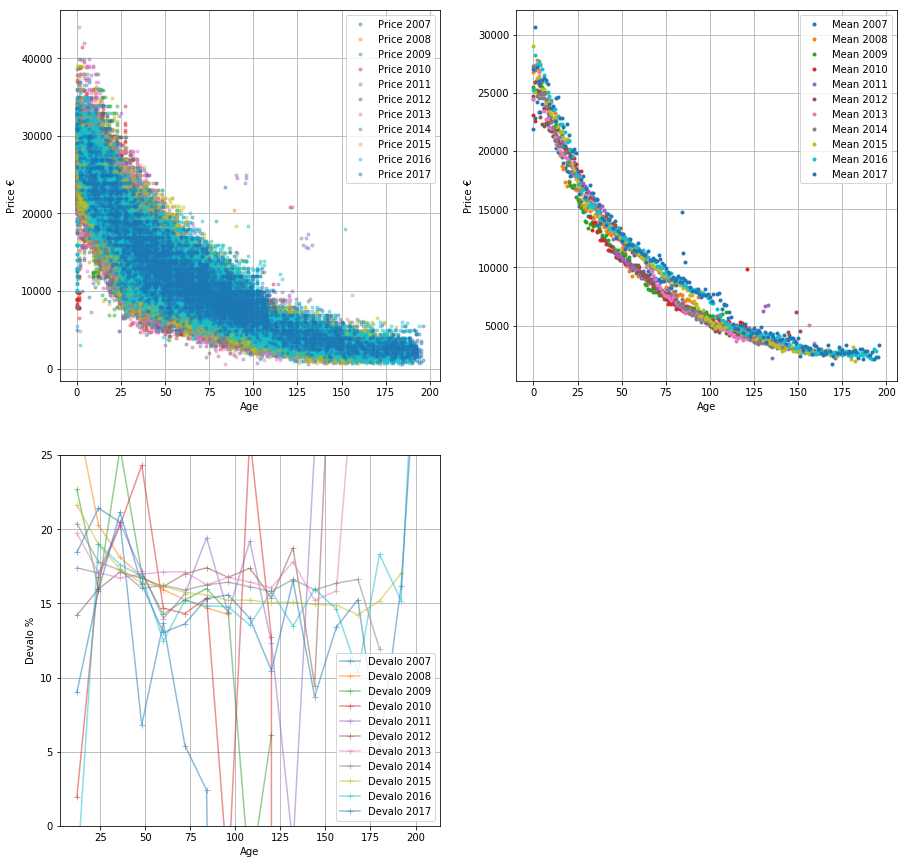

In [251]:
#name3 = '../../data_2017.csv'
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2, 2)
median_all = []
nb_cars = 0
for i,j in zip(liste,year_list):
    #df = pd.read_csv(i+'.gzip', sep='\t', dtype=str,compression='gzip')
    
    #df = pd.read_csv(i+'.gzip', sep=';', dtype=str, compression='gzip')
    #print(len(df))
    #print(list(df))
    
    df_model, cols = func_select(i, model)                              # clean the dataframe
    if(len(df_model)>1):
        head = list(df_model)
        df_model = func_treatment(df_model,head,year_min, cols)             # make the treatment of the subdataframe
    
        df_select= func_outliers(df_model)                                  # reduce the parameters space
        nb_cars += len(df_select)                                           # save the cars' number 
        df_results = func_mean_median(df_select, 'Age_months')              # compute the mean median per age
        df_results = df_results.sort_values(by='Age_months')                # sort the dataframe 
    
        print(j, len(df_select), 'rows', nb_cars, 'cars')
    
    # ---- Depreciation ----------------------------------------------------------------------------------------------
    # ---- Polynomial fit
    
        p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
        df = df_results
        param_poly, ier = leastsq(err_poly, p1, args=(df.Age_months,df.km,df.Mean), maxfev=50000)
    # ---- Exponential fit
        p0=[param_poly[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
        param_exp, ier = leastsq(err, p0, args=(df.Age_months,df.km,df.Mean), maxfev=50000)
        p2=[param_poly[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
        pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df.Age_months,df.km,\
                                                               df.Mean), full_output=1, epsfcn=0.000001)
        pfit_results, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df.Age_months,df.km,\
                                                                 df.Mean), full_output=1, epsfcn=0.0000001)
        y_new = func_exp2(pfit_results, df.Age_months,df.km)   # values of the price with the model
        df.Age_months[:5]
        #df_results['New_Price']=y_new
        devalo, x = func_annual_devalo3(y_new)
        
    # ---- Make a visual representation of this data -----------------------------------------------------------------
    
    #median_all.append(df_select[df_select.Age_months==0].Prix.median(0))
        ax1 = plt.subplot(gs[0, 0])
        plt.plot(df_select.Age_months, df_select.Prix, '.', alpha=0.4,label='Price '+str(j))
    #plt.ylim(0, np.amax(np.array(median_all))+10000)
        plt.legend()
        plt.xlabel('Age')
        plt.ylabel('Price €')
        plt.grid(True)
    
        ax2 = plt.subplot(gs[0, 1])
    #plt.plot(df_results.Age_months, df_results.Mean, '.', label='Mean '+str(j))
        plt.plot(df_results.Age_months, df_results.Mean, '.', label='Mean '+str(j))
        plt.legend()
        plt.xlabel('Age')
        plt.ylabel('Price €')
        plt.grid(True)


        ax3 = plt.subplot(gs[1, :-1])
    #plt.plot(df_results.Age_months, df_results.Mean, '.', label='Mean '+str(j))
        plt.plot(x, devalo, '+-',alpha=0.5, label='Devalo '+str(j))
        plt.ylim(0, 25)
        plt.legend()
        plt.xlabel('Age')
        plt.ylabel('Devalo %')
        plt.grid(True)


The previous figure shows the global behavior of a model per year (left) and the mean of this data (right).

<span style="color:blue"><font size="5">II - Comparaison between the all data and the last year</font></span>

The next is to compare the all datasets and the last year of the data. For our case is to compare 2007-2017 data to 2017. 

First, make a subdataframe and the computation for the year 2017. 

In [215]:
df_model, cols = func_select(df_2017, model)                        # select and clean the data for the year 2017
head = list(df_model)
df_model = func_treatment(df_model,head,year_min, cols)             # make the treatment of the subdataframe
    
df_select_2017= func_outliers(df_model)                             # Reduce the size of the samples
nb_cars  = len(df_select_2017)                                      # final number of cars
df_results = func_mean_median(df_select_2017, 'Age_months')         # compute the mean median of the Price in the data
df_results_2017 = df_results.sort_values(by='Age_months')
print("The cars' number is {}".format(nb_cars))

The cars' number is 6086


Next, the data will be stacked in a global dataframe and reduce. 

In [216]:
t = []                                                                   # empty list
for i,j in zip(liste,year_list):                                         # double loop on dataframe name and year
    df = i[i.Modele==model]                                             # make selection 
    t.append(df)                                                         # save the subdataframe on a list
    
df_concat = pd.concat(t, axis=0)                                         # concatenate all the subdataframe in the list
print('The size of the dataframe is {} rows'.format(len(df_concat)))

The size of the dataframe is 1021513 rows


Clean and reduce it. 

In [217]:
# Make computations with this dataframe
df_model, cols = func_select(df_concat, model)                           # Func to select subdataframe
head = list(df_model)                                                    # header of the df

In [218]:
df_model = func_treatment(df_model,head,year_min, cols)                  # make the treatment of the subdataframe
df_select= func_outliers(df_model)                                       # clean data 
print('The size of the select dataframe is {} rows '.format(len(df_select)))
df_histo = func_mean_median(df_select, 'Age_months')                     # compute the mean median of the dataframe

The size of the select dataframe is 248911 rows 


And then visualise it. 

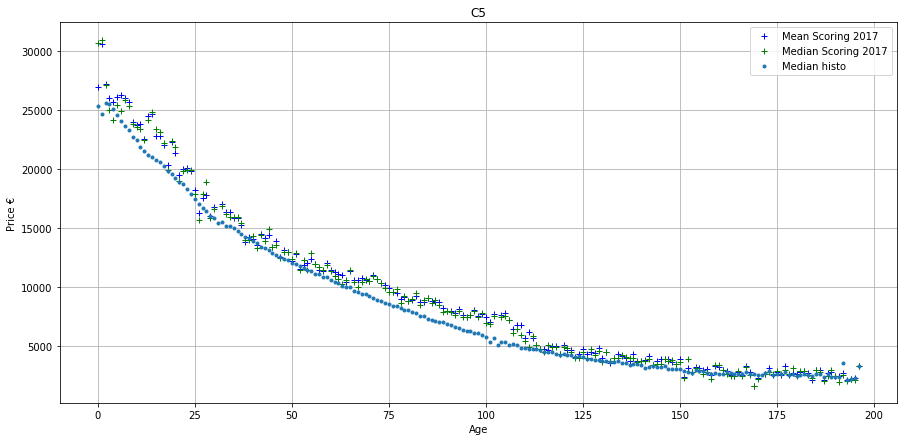

In [219]:
# Comparaison between the last year (2017) and the all datasets 
fig = plt.figure(figsize=(15,7))                                           # size of the figure
# ---- Year : 2017 ----------------------------------------------------------------------------------------------------
plt.plot(df_results_2017.Age_months, df_results_2017.Mean, 'b+', label='Mean Scoring 2017')     # plot of the mean
plt.plot(df_results_2017.Age_months, df_results_2017.Median, 'g+', label='Median Scoring 2017') # plot of the median

# ---- All data -------------------------------------------------------------------------------------------------------
plt.plot(df_histo.Age_months, df_histo.Mean, '.', label='Median histo')    # plot the mean of all the data 
plt.legend()
plt.title(model)
plt.xlabel('Age')
plt.ylabel('Price €')
plt.grid(True)

Two manners of the chi squares computation. 

In [220]:
chisquare(df_results_2017.Mean,df_histo[:len(df_results_2017)].Mean )[0]/(len(df_results_2017)-1)

22397.22488769086

In [221]:
chi2, p, dof, expected = chi2_contingency([df_results_2017.Mean,df_histo[:len(df_results_2017)].Mean])
print(chi2/(len(df_results_2017)-1), p)

6023.67675911 0.0


<span style="color:blue"><font size="5">III - Comparaison between one year extraction and the all data</font></span>

Like say previously, a file containing one year extraction of the site '<i>lacentrale.fr</i>' are available and can be used to compare with the global data and the last yeat (2017). 

Proceed with the dataframe of the site. 

In [222]:
df_model, cols = func_select(df_lacentrale, model)                 # make a subdataframe 
head = list(df_model)
data_month = df_model.data_month.values                            # save the data of the extraction, it's not in the 
data_month = [i.split('/') for i in data_month]                    # good format so it's needed to be split and 
data_month = [i[2]+'_'+i[1] for i in data_month]                   # construct to be used in the function 
df_model.data_month = data_month                                   # func_treatment
df_model = func_treatment(df_model,head,year_min, cols)            # make the treatment of the subdataframe
    
df_select= func_outliers(df_model)                                 # reduce the size of the sample 
nb_cars += len(df_select) 
df_results = func_mean_median(df_select, 'Age_months')             # compute mean and median 
df_results2 = df_results.sort_values(by='Age_months')

Quick visualisation to compare the different data. 

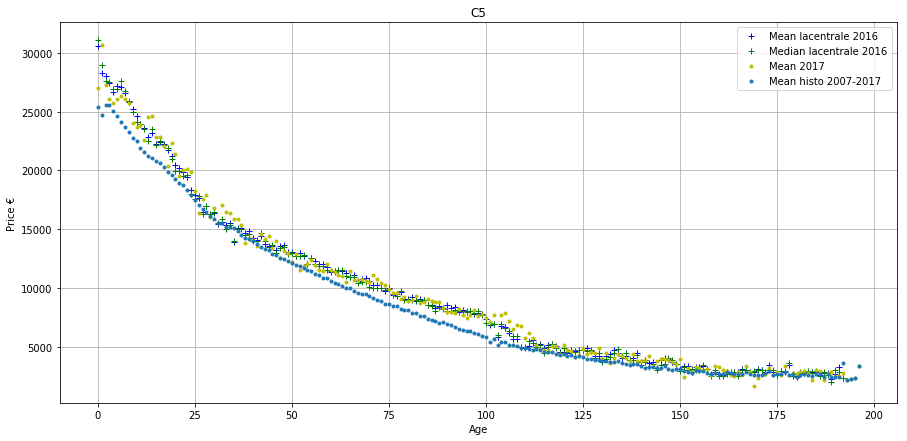

In [223]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_results2.Age_months, df_results2.Mean, 'b+', label='Mean lacentrale 2016')
plt.plot(df_results2.Age_months, df_results2.Median, 'g+', label='Median lacentrale 2016')
plt.plot(df_results_2017.Age_months, df_results_2017.Mean, 'y.', label='Mean 2017')
plt.plot(df_histo.Age_months, df_histo.Mean, '.', label='Mean histo 2007-2017')
plt.legend()
plt.title(model)
plt.xlabel('Age')
plt.ylabel('Price €')
plt.grid(True)

Make different computations to estimate the chi square. 

In [224]:
chisquare(df_results2.Mean,df_histo[:len(df_results2)].Mean )[0]/(len(df_results2)-1)

21999.613519284587

In [225]:
if(len(df_results2.Mean)<len(df_histo.Mean)):
    chi2, p, dof, expected = chi2_contingency([df_results2.Mean,df_histo[:len(df_results2)].Mean ])
    print(chi2/(len(df_results2)-1), p)
elif(len(df_results2.Mean)>len(df_histo.Mean)):
    chi2, p, dof, expected = chi2_contingency([df_results2[:len(df_histo)].Mean,df_histo.Mean ])  
    print(chi2/(len(df_histo)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([df_results2.Mean,df_histo.Mean ])      
    print(chi2/(len(df_results2)-1), p)

5871.40772647 0.0


In [226]:
if(len(df_results2.Mean)<len(df_results_2017.Mean)):
    chi2, p, dof, expected = chi2_contingency([df_results2.Mean,df_results_2017[:len(df_results2)].Mean ])
    print(chi2/(len(df_results2)-1), p)
elif(len(df_results2.Mean)>len(df_results_2017.Mean)):
    chi2, p, dof, expected = chi2_contingency([df_results2[:len(df_results_2017)].Mean,df_results_2017.Mean ])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([df_results2.Mean,df_results_2017.Mean ])      
    print(chi2/(len(df_results_2017)-1), p)

25.1073245072 0.0


The chi square between the global data and the last year are closed to the chi square computed with the one extract year on the site. The last year in the data are in good agreement with their crawl on the site. 

<span style="color:blue"><font size="5">IV - Modelisation </font></span>

<span style="color:green"><font size="4">1 - Last year (2017)  </font></span>

Begin by the last year in the historique. The first fit is a polynomial fit determine by the least squares method to determine an estimation of the price at the instant 0. This value wiil serve to the exponential fit to have a less parameters map. 

In [227]:
p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
df = df_select_2017
param_2017, ier = leastsq(err_poly, p1, args=(df.Age_months,df.km,\
                                         df.Prix), maxfev=5000000)
print(param_2017)

[  2.69896780e+04  -2.57814480e+02  -6.39530930e-02   1.52594931e+00
   1.55003387e-07  -3.61142381e-03  -8.22792444e-14]


Now, try an exponential fit. 

In [228]:
p0=[param_2017[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
param_exp, ier = leastsq(err, p0, args=(df.Age_months,df.km,df.Prix), maxfev=500000)

p2=[param_2017[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df.Age_months,df.km,\
                                                               df.Prix), full_output=1, epsfcn=0.000001)
pfit_2017, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df.Age_months,df.km,\
                                                                 df.Prix), full_output=1, epsfcn=0.0000001)

print(param_exp, ier)
print(pfit_2017)

[  3.08705366e+04  -1.02318964e-01   9.78935719e-01   9.85090202e-01
  -1.02448623e-02  -4.01610133e-06] 1
[  2.34274916e+04   1.73741003e-01   9.78170842e-01   9.85840623e-01
  -1.02848281e-02  -3.97878090e-06]


The fits doesn't return an error so, a potential mathematical approach could be determine by the data. Now, generate the new price for the couple (age,km). 

In [229]:
df = df_results_2017
df = df.sort_values('Age_months')
y_2017 = func_exp2(param_exp, df.Age_months,df.km)   # values of the price with the model
y_2017_2= func_exp2(pfit_2017, df.Age_months,df.km)        # values of the price with the model
df['New_price']=y_2017_2
df['Shift']=y_2017_2/y_2017_2.shift(+1)
devalo_2017, x_2017 = func_annual_devalo3(y_2017_2)
print(y_2017_2[:5])
print(devalo_2017)
print(df[['Age_months', 'Mean', 'New_price', 'Shift']])
100-100*pow(df['Shift'][12:24].mean(),12)

193    26152.036627
188    27140.124796
189    26804.668563
191    26764.340806
192    26591.516606
dtype: float64
[9.1040890475442922, 14.841794816119005, 21.748399288578241, 16.655376337953669, 11.742738398945079, 12.48107307845892, 15.296441579914728, 15.954012952582772, 12.02081785140318, 6.1307973174739914, 16.618357994498581, 1.9950122437072224, 10.143179733146411, 7.7661965727457272, -10.236823991885814, 16.104022641229093, 54.379785899312353]
     Age_months          Mean     New_price     Shift
193           0  27002.705882  26152.036627       NaN
188           1  30631.428571  27140.124796  1.037782
189           2  27247.500000  26804.668563  0.987640
191           3  26039.000000  26764.340806  0.998495
192           4  25752.909091  26591.516606  0.993543
190           5  26111.714286  25928.881327  0.975081
186           6  26312.142857  25968.197389  1.001516
187           7  26065.195122  25382.253219  0.977436
183           8  25744.785714  25074.657917  0.987881
181  

14.841794816119005

Next step the visualtion. 

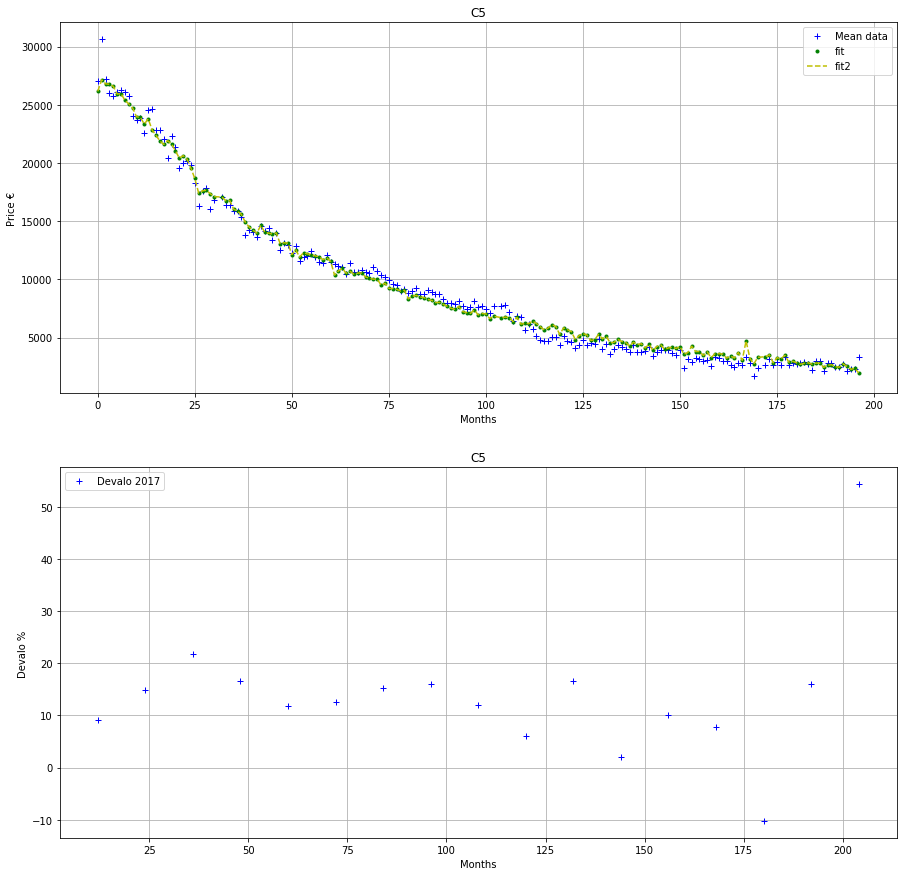

In [230]:
fig = plt.figure(figsize=(15,15))                                            # size of the all picture
ax1 = plt.subplot(211)                                                     # first subplot 1/4 
plt.plot(df.Age_months, df.Mean, 'b+', alpha=1,label='Mean data') # All the data, plot price = f(age)
plt.plot(df.Age_months, y_2017, 'g.', label='fit')              # Fit of the all data 
plt.plot(df.Age_months, y_2017_2, 'y--', label='fit2')           # Fit of the all data 
#plt.ylim(-1000,np.amax(y_New)+10000)                           # resize the figure 
plt.legend()
plt.title(model)
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax2 = plt.subplot(212)                                                     # first subplot 1/4 
plt.plot(x_2017, devalo_2017, 'b+', alpha=1,label='Devalo 2017') # All the data, plot price = f(age)
plt.legend()
plt.title(model)
plt.xlabel('Months')
plt.ylabel('Devalo % ')
plt.grid(True)

The fit seems to be in good agreement with the data. To be sure, it's important to compute the chi2 estimator. 

In [231]:
a = y_2017 
b = df_results_2017.Mean
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

31.7596820197 0.0


In [232]:
a = y_2017_2 
b = df_results_2017.Mean
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(b)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

31.7972421019 0.0


Two exponential fits were computed, the result of the reduce chi square are interesting, the second fit is better than the first and confirm the visual conclusion that the fit is in good agreement. 

<span style="color:green"><font size="4">2 - Year 2016 on <i>lacentrale.fr</i>  </font></span>

After compute the last year of the all data, it's interesting to compare with the one year extraction (2016) on the site <i>lacentrale.fr</i>.

In [233]:
p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
df = df_results2
param, ier = leastsq(err_poly, p1, args=(df.Age_months,df.km,df.Mean), maxfev=5000000)
print(param)

[  2.83372662e+04  -1.19231103e+02  -2.27550247e-01  -2.95237405e-01
   1.81829027e-06   2.46251936e-03  -4.60881289e-12]


In [234]:
p0=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
param_exp, ier = leastsq(err, p0, args=(df.Age_months,df.km,df.Mean), maxfev=500000)

p2=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df.Age_months,df.km,\
                                                               df.Mean), full_output=1, epsfcn=0.000001)
pfit_lacentrale, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df.Age_months,df.km,\
                                                                 df.Mean), full_output=1, epsfcn=0.0000001)

print(param_exp, ier)
print(pfit_lacentrale)

[  2.88881610e+04   6.46958828e-02   1.35258958e+00   5.09244994e-01
  -1.57514006e-03  -1.70994987e-03] 1
[  2.97936494e+04   3.39786261e-02   1.35394548e+00   5.09121149e-01
  -1.56371257e-03  -1.71463821e-03]


In [235]:
y_lacentrale = func_exp2(param_exp, df.Age_months,df.km)   # values of the price with the model
y_lacentrale2= func_exp2(pfit_lacentrale, df.Age_months,df.km)        # values of the price with the model
#df_results2 = df_results2.sort_values('Age_months')
#df_results2['New_price']=y_lacentrale
df_results2['New_price2']=y_lacentrale2
df_results2['devalo_month']=df_results2['New_price2']/df_results2['New_price2'].shift(+1)
devalo_lacentrale, x_lacentrale = func_annual_devalo3(y_lacentrale2)
a = y_lacentrale2 / y_lacentrale2.shift(+1)
#100-100*pow(a[24:36].mean(),12)
df_results2[['Age_months', 'New_price2', 'devalo_month']][:12]
#func_annual_devalo3(df_results2['devalo_month'])

,Age_months,New_price2,devalo_month
192,0,28070.734509,NaN
191,1,28897.881376,1.029467
190,2,28353.130991,0.981149
186,3,28030.835189,0.988633
187,4,27858.868379,0.993865
188,5,27251.562373,0.978201
189,6,26740.665248,0.981253
182,7,26311.585378,0.983954
183,8,25687.003744,0.976262
184,9,25209.210073,0.981399


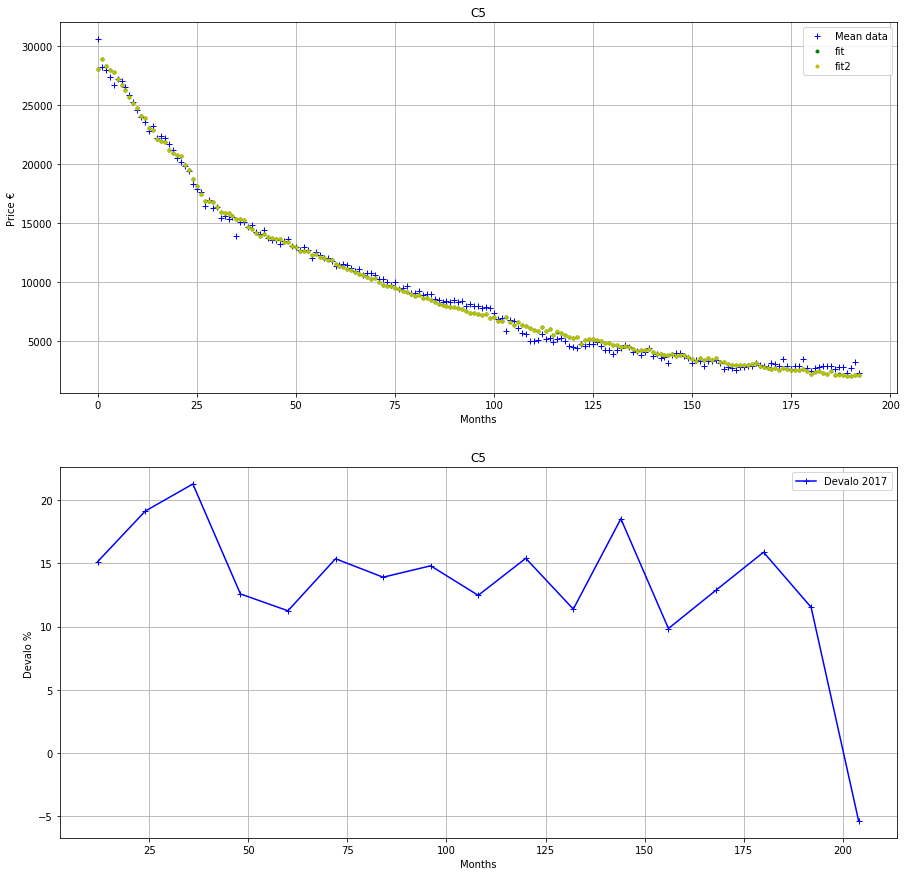

In [236]:
fig = plt.figure(figsize=(15,15))                                            # size of the all picture
ax1 = plt.subplot(211)                                                     # first subplot 1/4 
plt.plot(df.Age_months, df.Mean, 'b+', alpha=1,label='Mean data') # All the data, plot price = f(age)
plt.plot(df.Age_months, y_lacentrale, 'g.', label='fit')              # Fit of the all data 
plt.plot(df.Age_months, y_lacentrale2, 'y.', label='fit2')           # Fit of the all data 
#plt.ylim(-1000,np.amax(y_New)+10000)                           # resize the figure 
plt.legend()
plt.title(model)
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax2 = plt.subplot(212)                                                     # first subplot 1/4 
plt.plot(x_lacentrale, devalo_lacentrale, 'b+-', alpha=1,label='Devalo 2017') # All the data, plot price = f(age)
plt.legend()
plt.title(model)
plt.xlabel('Months')
plt.ylabel('Devalo % ')
plt.grid(True)

In [237]:
a = y_lacentrale 
b = df.Mean
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

18.1394003526 0.0


In [238]:
a = y_lacentrale2 
b = df.Mean
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

18.1534816275 0.0


<span style="color:green"><font size="4">3 - Historique (2007-2017)  </font></span>

In [239]:
p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
df = df_histo
param, ier = leastsq(err_poly, p1, args=(df.Age_months,df.km,df.Mean), maxfev=5000000)
print(param)

[  2.61012260e+04  -2.07542194e+02  -9.90708319e-02   7.05277639e-01
   5.24312774e-07  -5.02679194e-04  -9.00599470e-13]


In [240]:
p0=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
param_exp, ier = leastsq(err, p0, args=(df.Age_months,df.km,df.Mean), maxfev=500000)

p2=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df.Age_months,df.km,\
                                                               df.Mean), full_output=1, epsfcn=0.000001)
pfit, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df.Age_months,df.km,\
                                                                 df.Mean), full_output=1, epsfcn=0.0000001)

print(param_exp, ier)
print(pfit)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in exp


[  2.62571279e+04  -2.99391774e-03   8.93528378e-01   1.54726579e+00
  -1.75543283e-02  -4.44888068e-09] 1
[  2.61553764e+04   8.72123802e-04   8.93398291e-01   1.54819391e+00
  -1.75622183e-02  -4.40203120e-09]


In [241]:
y_histo = func_exp2(param_exp, df_histo.Age_months,df_histo.km)   # values of the price with the model
y_histo2= func_exp2(pfit, df_histo.Age_months,df_histo.km)   # values of the price with the model
df_histo = df_histo.sort_values('Age_months')


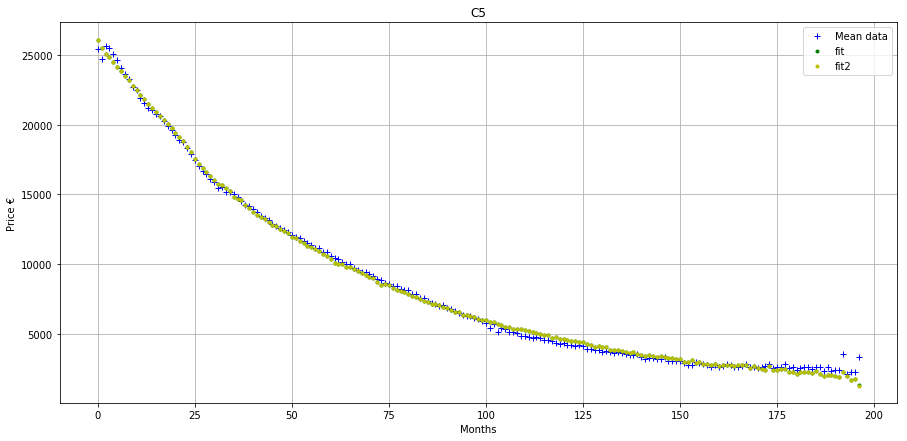

In [242]:
fig = plt.figure(figsize=(15,7))                                            # size of the all picture
#ax1 = plt.subplot(211)                                                     # first subplot 1/4 
plt.plot(df.Age_months, df.Mean, 'b+', alpha=1,label='Mean data') # All the data, plot price = f(age)
plt.plot(df.Age_months, y_histo, 'g.', label='fit')              # Fit of the all data 
plt.plot(df.Age_months, y_histo2, 'y.', label='fit2')           # Fit of the all data 
#plt.ylim(-1000,np.amax(y_New)+10000)                           # resize the figure 
plt.legend()
plt.title(model)
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)

Compare y_New et y_New2 

In [243]:
a = y_histo 
b = df.Mean
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

12.6064271817 0.0


In [244]:
a = y_histo2 
b = df.Mean
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

12.6082976463 0.0


<span style="color:green"><font size="4">4 - Comparaison between 2017 and <i>lacentrale.fr</i>  </font></span>

To make a comparaison, the fit will be used on the two sets with the parameters of each other. 

In [245]:
y = func_exp2(pfit_2017, df_results2.Age_months, df_results2.km)
y2= func_exp2(pfit_lacentrale, df_results_2017.Age_months, df_results_2017.km)


Now the new prices were calculated with the coefficients of the other fit. Now, visualise the two differences. 

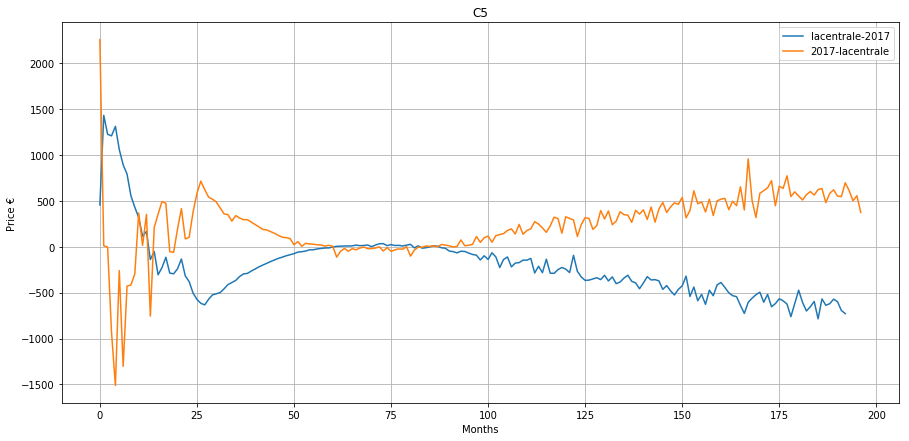

In [246]:
fig = plt.figure(figsize=(15,7))                                            # size of the all picture
plt.plot(df_results2.Age_months,y_lacentrale2-y, alpha=1,label='lacentrale-2017') # All the data, plot price = f(age)
plt.plot(df_results_2017.Age_months,y_2017_2-y2, alpha=1,label='2017-lacentrale') # All the data, plot price = f(age)
plt.legend()
plt.title(model)
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)

In [247]:
'The difference is {}€'.format(int((y_lacentrale2-y).mean()))

'The difference is -215€'

In [248]:
'The difference is {}€'.format(int((y_2017_2-y2).mean()))

'The difference is 234€'

In [249]:
a = y_2017 
b = y_lacentrale
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

17.3888349344 0.0


In [250]:
a = y_2017_2 
b = y_lacentrale2
if(len(a)<len(b)):
    chi2, p, dof, expected = chi2_contingency([a,b[:len(a)]])
    print(chi2/(len(a)-1), p)
elif(len(a)>len(b)):
    chi2, p, dof, expected = chi2_contingency([a[:len(b)],b])  
    print(chi2/(len(df_results_2017)-1), p)
else:
    chi2, p, dof, expected = chi2_contingency([a,b])      
    print(chi2/(len(b)-1), p)

17.4717015238 0.0


Compare 2017 et les fits 

<span style="color:blue"><font size="5">V - Conclusion </font></span>

1- 
Fit par année
Modélisation de la dévalo par année ? 
2- 
Neural Netwoork 
3- 
Etude economique 